## Вычисление линейного тренда

Линейный тренд: $y = ax + b$, где
$$
a = \rho \frac{s_y}{s_x}, \\
b = \overline{y} - a \overline{x},
$$
$\rho$ - коэффициент корреляции, $s_x, s_y$ - стандартные отклонения

0.07051561380739452 -120.66586813905559


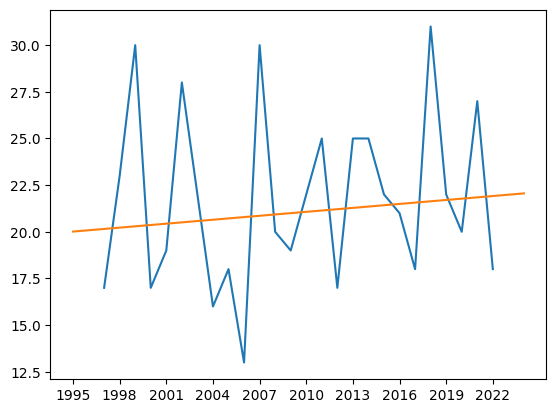

In [1]:
import numpy as np
import math
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt


# Дневная погода в казани за 1 июля 1997-2022гг.
x = np.array([year for year in range(1997, 2023)])
y = np.array([17, 23, 30, 17, 19, 28, 22, 16, 18,
              13, 30, 20, 19, 22, 25, 17, 25, 25,
              22, 21, 18, 31, 22, 20, 27, 18])
assert x.size == y.size
n = y.size

r = stats.correlation(x, y)
mean_x = stats.mean(x)
mean_y = stats.mean(y)
s_x = stats.pstdev(x)
s_y = stats.pstdev(y)

a = r * s_y / s_x
b = mean_y - a * mean_x
print(a, b)

sns.lineplot(x=x, y=y)
sns.lineplot(x=[x for x in range(1995, 2025)], y=[a*x + b for x in range(1995, 2025)])
plt.xticks(range(1995, 2025, 3))
plt.show()

## Вычисление линейного тренда (сглаженного временного ряда)

Уравнение лин тренда: y =  0.06621846934651697 * x + -112.03290491715259


([<matplotlib.axis.XTick at 0x7f27e91ac250>,
 [Text(1995, 0, '1995'),
  Text(1998, 0, '1998'),
  Text(2001, 0, '2001'),
  Text(2004, 0, '2004'),
  Text(2007, 0, '2007'),
  Text(2010, 0, '2010'),
  Text(2013, 0, '2013'),
  Text(2016, 0, '2016'),
  Text(2019, 0, '2019'),
  Text(2022, 0, '2022')])

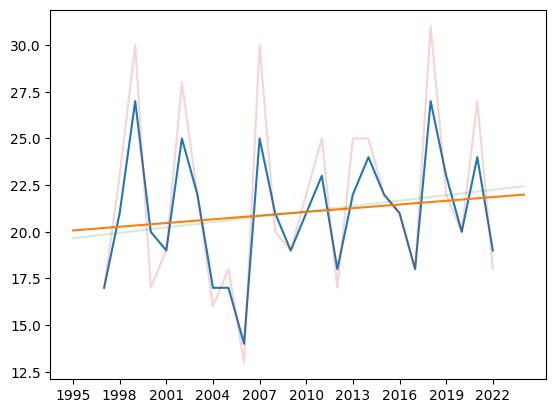

In [1]:
import numpy as np
import math
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt
import scipy.stats as sps


def smooth_exponential(series, *, a = None):
    if not a:
        a = 2 / (len(series) + 1)
    smoothed_series = series.copy()

    for i in range(1, len(series)):
        smoothed_series[i] = a * series[i] + (1 - a) * smoothed_series[i - 1]
    
    return smoothed_series


# Дневная погода в казани за 1 июля 1997-2022гг.
x = np.array([year for year in range(1997, 2023)])
y_old = np.array([17, 23, 30, 17, 19, 28, 22, 16, 18,
                  13, 30, 20, 19, 22, 25, 17, 25, 25,
                  22, 21, 18, 31, 22, 20, 27, 18])
y = smooth_exponential(y_old, a=0.7)
assert x.size == y.size
n = y.size

r = stats.correlation(x, y)
mean_x = stats.mean(x)
mean_y = stats.mean(y)
s_x = stats.pstdev(x)
s_y = stats.pstdev(y)

a = r * s_y / s_x
b = mean_y - a * mean_x
print('Уравнение лин тренда: y = ', a, '* x +', b)


r_old = stats.correlation(x, y_old)
mean_y_old = stats.mean(y_old)
s_y_old = stats.pstdev(y_old)

a_old = r * s_y_old / s_x
b_old = mean_y_old - a_old * mean_x


sns.lineplot(x=x, y=y)
sns.lineplot(x=[x for x in range(1995, 2025)], y=[a*x + b for x in range(1995, 2025)])
sns.lineplot(x=[x for x in range(1995, 2025)], y=[a_old*x + b_old for x in range(1995, 2025)], alpha=0.2)
sns.lineplot(x=x, y=y_old, alpha=0.2)
plt.xticks(range(1995, 2025, 3))

## Проверка условий МНК

$\epsilon = y_{экс}-y_{расч}$

### Условия

1. $E\epsilon = 0$
2. $D\epsilon = const$
3. $\epsilon_i$ - случайные величины
4. $\epsilon_i$ не зависит от $\epsilon_j$
5. $\epsilon$ имеет нормальное распределение

In [ ]:
eps = [y[t] - (a*(t + 1997) + b) for t in range(n)]
## 1
print('E(eps) =', stats.mean(eps))

## 2
n1 = 9
n2 = 17
sigma1l = sum(e**2 for e in eps) / int(n1 - (1+1))
sigma3l = sum(eps[i]**2 for i in range(n2, n)) / int(n - n2 - (1+1))
fisher = sps.f.ppf(0.025, n1 - (1+1), n - n2 - (1+1))
print('Гипотеза о постоянстве дисперсий с надежностью 0.05:', fisher, '<', sigma3l / sigma1l, '<', 1/fisher)


## 3
p = 0
for i in range(1, len(eps)-1):
    if (eps[i-1] < eps[i] > eps[i+1]) or (eps[i-1] > eps[i] and eps[i] < eps[i+1]):
        p += 1
q = int(2/3 * (n-2) - 1.96 * math.sqrt((16*n - 29) / 90))
print('Условие случайности остатков:', p, '>', q)

## 4 DW alpha = 0.05, dL = 1.33, dU = 1.46
d = sum((eps[i] - eps[i-1])**2 for i in range(1, n)) / sum(e**2 for e in eps)
d1 = 1.33
d2 = 1.46
if d2 < d < 4-d2:
    print('Остатки некореллированы')
elif 0 < d < d1:
    print('Положительная автокорелляция остатков')
elif 4-d1 < d < 4:
    print('Отрицательная автокорелляция остатков')
elif d1 < d < d2 or 4-d2 < d < 4-d1:
    print('Неопределенность')

## 5
# emax = max(eps)
# emin = min(eps)
# e_stdev = stats.stdev(eps)
# rstest = (emax - emin) / e_stdev
_, pval = sps.kstest(eps, 'norm')
if pval <= 0.05:
    print('Принимается гипотеза о нормальном распределении остатков с надежностью 0.05')
else:
    print('Отвергается гипотеза о нормальном распределении остатков с надежностью 0.05')

sns.lineplot(eps)

: 

## Построение коррелограммы

Коэффициент автокорреляции:
$$
r(\tau) = \frac{(n - \tau) \sum_{t=1}^{n-\tau} y_t y_{t+\tau} - \sum_{t=1}^{n-\tau} y_t \sum_{t=1}^{n-\tau} y_{t+\tau}}
{\sqrt{[(n-\tau) \sum_{t=1}^{n-\tau} y_t^2 - (\sum_{t=1}^{n-\tau} y_t) ^ 2][(n-\tau) \sum_{t=1}^{n-\tau} y_{t+\tau}^2 - (\sum_{t=1}^{n-\tau} y_{t+\tau})^2]}}
$$

In [ ]:
y = np.array([17, 23, 30, 17, 19, 28, 22, 16, 18,
                    13, 30, 20, 19, 22, 25, 17, 25, 25,
                    22, 21, 18, 31, 22, 20, 27, 18])

taus = list(range(15))
autocorr_coefs = []

for tau in range(15):
    a = (n - tau) * sum(y[t] * y[t+tau] for t in range(0, n-tau-1))
    b = sum(y[t] for t in range(0, n-tau-1)) * sum(y[t+tau] for t in range(0, n-tau-1))
    c = (n - tau) * sum(y[t] ** 2 for t in range(0, n-tau-1))
    d = sum(y[t] for t in range(0, n-tau-1)) ** 2
    e = (n - tau) * sum(y[t+tau] ** 2 for t in range(0, n-tau-1))
    f = sum(y[t+tau] for t in range(0, n-tau-1)) ** 2

    r = (a - b) / math.sqrt((c - d) * (e - f))
    autocorr_coefs.append(r)


plt.plot(taus, autocorr_coefs, 'k.')
plt.plot(taus, autocorr_coefs, 'k-', alpha=0.5)
plt.xticks(range(15))


: 

## Построение кореллограммы (сглаженного временного ряда)

In [ ]:
y_old = np.array([17, 23, 30, 17, 19, 28, 22, 16, 18,
                    13, 30, 20, 19, 22, 25, 17, 25, 25,
                    22, 21, 18, 31, 22, 20, 27, 18])
y = smooth_exponential(y_old)

taus = list(range(15))
autocorr_coefs = []

for tau in range(15):
    a = (n - tau) * sum(y[t] * y[t+tau] for t in range(0, n-tau-1))
    b = sum(y[t] for t in range(0, n-tau-1)) * sum(y[t+tau] for t in range(0, n-tau-1))
    c = (n - tau) * sum(y[t] ** 2 for t in range(0, n-tau-1))
    d = sum(y[t] for t in range(0, n-tau-1)) ** 2
    e = (n - tau) * sum(y[t+tau] ** 2 for t in range(0, n-tau-1))
    f = sum(y[t+tau] for t in range(0, n-tau-1)) ** 2

    r = (a - b) / math.sqrt((c - d) * (e - f))
    autocorr_coefs.append(r)


plt.plot(taus, autocorr_coefs, 'k.')
plt.plot(taus, autocorr_coefs, 'k-', alpha=0.5)
plt.xticks(range(15))

: 